In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2


In [2]:
data = pd.read_csv('data.csv', header = 0)
data.head()

,Unnamed: 0,id,text,author
0,0,id26305,"This process, however, afforded me no means of...",Dan Brown
1,1,id17569,It never once occurred to me that the fumbling...,Chetan Bhagat
2,2,id11008,"In his left hand was a gold snuff box, from wh...",Dan Brown
3,3,id27763,How lovely is spring As we looked from Windsor...,Rowling
4,4,id12958,"Finding nothing else, not even gold, the Super...",Chetan Bhagat


In [3]:
# select text and author column from data 
col = ['text', 'author']
df = data[col]

# assign numbers to authors [0,1,2]
df['category_id'] = df['author'].factorize()[0]
category_id_df = df[['author', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'author']].values)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,text,author,category_id
0,"This process, however, afforded me no means of...",Dan Brown,0
1,It never once occurred to me that the fumbling...,Chetan Bhagat,1
2,"In his left hand was a gold snuff box, from wh...",Dan Brown,0
3,How lovely is spring As we looked from Windsor...,Rowling,2
4,"Finding nothing else, not even gold, the Super...",Chetan Bhagat,1


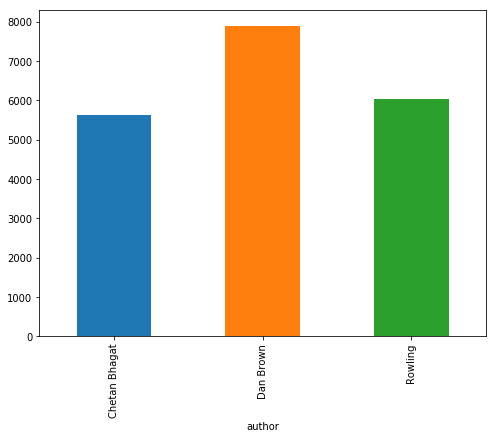

In [4]:
# check the doucment occurance of each other by ploting the count of document with respect to authors provided.
fig = plt.figure(figsize = (8,6))
data.groupby('author').text.count().plot.bar(ylim=0)
plt.show()

In [5]:
# Features genation using Term_frequency inverse document frequency calculation 
# tfidf vectorizer is calculated removing the stopwards and ngram values (1,2) which is unigram to bigram range combiniation.
# normaized to ridge regression using l2 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.text).toarray()
labels = data.author
features.shape

(19579, 8715)

In [6]:
# features generated after performing Tf_idf which is the occurance of each word 
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
# commonly used unigram and bigram of each author
N = 2
for author, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(author))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Chetan Bhagat':
  . Most correlated unigrams:
. feels
. zest
  . Most correlated bigrams:
. feet height
. feet long
# 'Dan Brown':
  . Most correlated unigrams:
. feels
. zest
  . Most correlated bigrams:
. feet height
. feet long
# 'Rowling':
  . Most correlated unigrams:
. feels
. zest
  . Most correlated bigrams:
. feet height
. feet long


1. Split the data into test and train 
2. tfidf
3. multinomialNB()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['author'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [9]:
# predict the text writing style 
print(clf.predict(count_vect.transform(["It never once occurred to me that the fumbling might be a mere mistake."])))

print(clf.predict(count_vect.transform(["How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair."])))

print(clf.predict(count_vect.transform(["Herbert West needed fresh bodies because his life work was the reanimation of the dead."])))



['Dan Brown']
['Rowling']
['Chetan Bhagat']


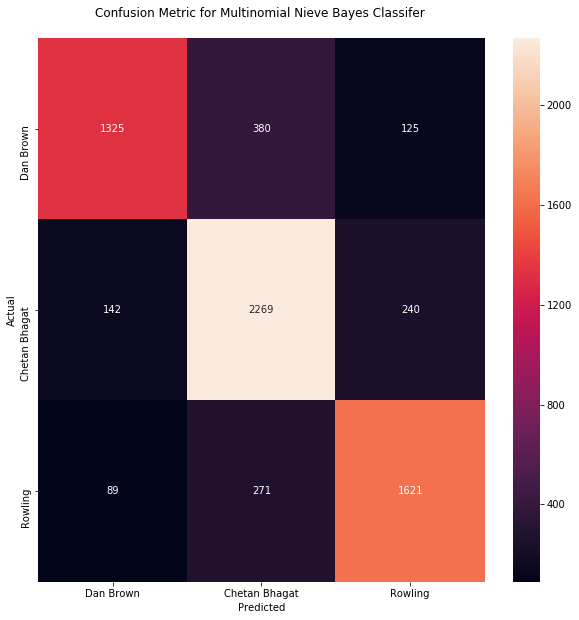

In [10]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.author.values, yticklabels=category_id_df.author.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Metric for Multinomial Nieve Bayes Classifer \n')
plt.show()